<a href="https://colab.research.google.com/github/ebatty/MathTools2023/blob/jupyterbook/Week3/Week3Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1

**Dynamical Systems I, Discrete Dynamics & Eigenstuff**

**[insert your name]**

**Important reminders**: Before starting, click "File -> Save a copy in Drive". Produce a pdf for submission by "File -> Print" and then choose "Save to PDF".

To complete this tutorial, you should have watched Videos 3.1, 3.2, and 3.3.



In [1]:
# @markdown Imports

# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg
from matplotlib.animation import FuncAnimation
import ipywidgets as widgets

# Plotting parameters
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams.update({'font.size': 22})

In [2]:
# @markdown Plotting functions
your_theme = 'white'
if your_theme == 'dark':
  plt.style.use(['dark_background'])
  classic = 'w'
else:
  classic = 'k'

def plot_eig_vec_transform(W):
  vec_names = ['a', 'b','c','d','e','f','g', 'h']

  _, vecs = np.linalg.eig(W)
  vecs = vecs.T

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  for i in range(2):
    axes[i].set(xlim=[-3.5, 3.5], ylim=[-3.5,3.5])
    axes[i].axis('Off')
    axes[i].plot([0, 0], [-3.5, 3.5], classic, alpha=.4)
    axes[i].plot([-3.5, 3.5], [0, 0], classic, alpha=.4)

  for i_vec, vec in enumerate(vecs):
    axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

    transformed_vec = np.matmul(W, vec)
    axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

  axes[0].set_title('Before')
  axes[1].set_title('After')
def plot_circuit_responses(u, W, eigenstuff = False, xlim='default', ylim='default'):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    # Set up axis limits
    if xlim =='default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      xlim = [- extreme, extreme]
    if ylim == 'default':
      extreme = np.maximum(np.abs(np.min(u)), np.max(u))
      ylim = [- extreme, extreme]

    # Set up look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    cs = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set up tracking textz
    tracker_text = ax.text(.5, .9, "", color='w', fontsize=20, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes)

    # Plot eigenvectors
    if eigenstuff:
      eigvals, eigvecs = np.linalg.eig(W)

      if np.abs(eigvals[0]) < np.abs(eigvals[1]):
        lc1 = 'c'
        lc2 = 'g'
      else:
        lc1 = 'g'
        lc2 = 'c'

      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 0], np.arange(-10000, 10000)*eigvecs[1, 0],lc1, alpha=.5, label = r'$\bar{v}_1$')
      ax.plot(np.arange(-10000, 10000)*eigvecs[0, 1], np.arange(-10000, 10000)*eigvecs[1, 1], lc2, alpha=.5, label = r'$\bar{v}_2$')

      ax.legend()

    # Set up scatter
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=0, vmax=u.shape[1])
    ax.plot(u[0,:], u[1, :], alpha=.4, zorder = 0)
    scatter = ax.scatter(u[0, :], u[1, :], alpha=1, c = cmap(norm(np.arange(u.shape[1]))), zorder = 1)


    ax.set(xlabel = 'Neuron 1 Firing Rate ($u_1$)', ylabel = 'Neuron 2 Firing Rate ($u_2$)', title = 'Neural firing over time')

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=ax, label = 'Time step')


In [3]:
# @markdown Helper functions

def get_eigval_specified_matrix(target_eig):
  """Generates matrix with specified eigvals

    Args:
      target_eig (list): list of target eigenvalues, can be real or complex,
              should be length 2 unless you desire repeated eigenvalues
              with the same eigenvector, in which case length 1

    Returns:
      ndarray: 2 x 2 matrix with target eigvals

  """

  # Set up two eigenvectors
  V = np.array([[1, 1], [-1, 1]]).astype('float')
  for i in range(2):
    V[:,i] = V[:,i]/np.linalg.norm(V[:,i])

  # Get matrix with target eigenvalues
  if type(target_eig[0]) == int or type(target_eig[0]) == float:

    if len(target_eig) == 2: # distinct eigvecs (not necessarily distinct eigvals)

        D = np.diag(target_eig)
        A = V @ D @ np.linalg.inv(V)

    else: # repeated with same vec
      summed = 2*target_eig[0]

      a = summed-3
      d = 3
      bc = target_eig[0]**2 - a*d
      factors = [n for n in range(1, bc+ 1) if bc % n == 0]
      b = factors[int(np.floor(len(factors)/2))]
      c = bc/-b

      A = np.array([[a, b], [c, d]])

  elif type(target_eig[0]) == complex:

      C = [np.real(V[:,0]), np.real(V[:,1])]
      B = np.array([[np.real(target_eig[0]), np.imag(target_eig[0])], [-np.imag(target_eig[0]), np.real(target_eig[0])]]).squeeze()
      A = C @ B @ np.linalg.inv(C)

  return A

# Exercise 1: Eigenvectors & transformations

## A) Identifying eigenvectors

Below we plot some vectors before a linear transformation by a matrix and after. Which of the vectors are eigenvectors?

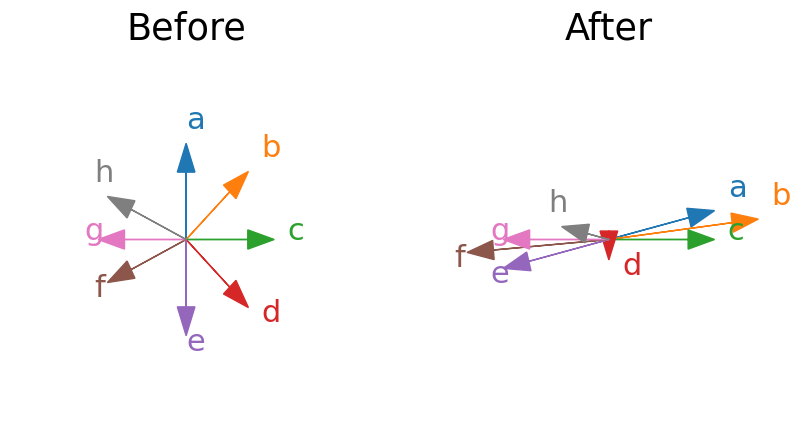

In [4]:
# @title
# @markdown Execute this cell to visualize vectors

vec_names = ['a', 'b','c','d','e','f','g', 'h']
vecs = np.array([[0, 1],
                 [1/np.sqrt(2), 1/np.sqrt(2)],
                 [1, 0],
                 [1/np.sqrt(2), -1/np.sqrt(2)],
                 [0, -1],
                 [-2/np.sqrt(5), -1/np.sqrt(5)],
                 [-1, 0],
                 [-2/np.sqrt(5), 1/np.sqrt(5)],
                 ])
W = np.array([[1.2, 1.2], [0, .3]])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(2):
  axes[i].set(xlim=[-2, 2], ylim=[-2,2])
  axes[i].axis('Off')

for i_vec, vec in enumerate(vecs):
  axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
  axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

  transformed_vec = np.matmul(W, vec)
  axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
  axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

axes[0].set_title('Before')
axes[1].set_title('After');

## B) Describing transformations with eigenvectors

Last week, we learned how to think about linear transformations in terms of where the unit vectors end up. We can also think about them in terms of eigenvectors. Just by looking at eigenvectors before and after a transformation, can you describe what the transformation is in words?

Note that I show an eigenvector for every eigenvalue. The x/y limits do not change in before vs after (so eigenvectors are showed scaled by the eigenvalues).


Here are some transformation words to jog your memory: contraction, expansion, horizontal vs vertical, shear, projection onto an axis, reflection.

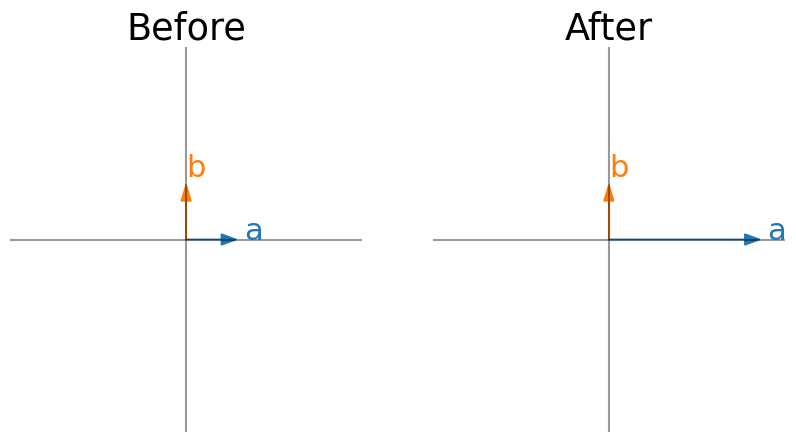

In [5]:
# @title
# @markdown Execute this cell to visualize vectors

W = np.array([[3, 0], [0, 1]])
plot_eig_vec_transform(W)


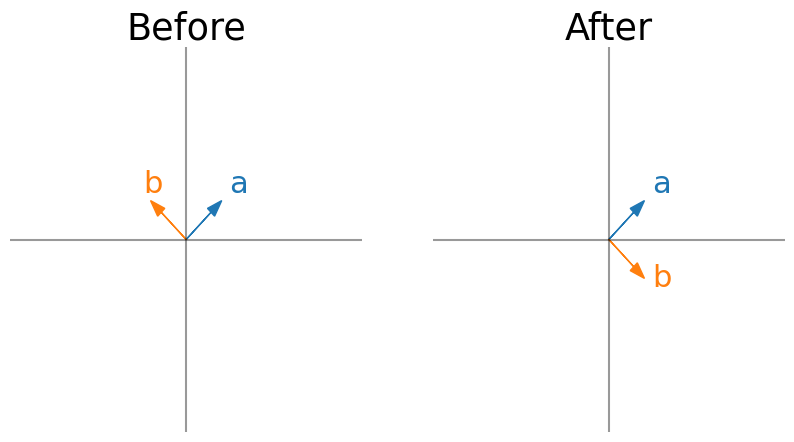

In [6]:
# @title
# @markdown Execute this cell to visualize vectors

W = np.array([[0, 1], [1, 0]])
plot_eig_vec_transform(W)

# Exercise 2: Eigenstuff of a matrix squared

This is a guided proof. Consider the matrix $A$ with eigenvalues $\lambda$. We want to answer the following question: what are the eigenvectors and eigenvalues of $A^2$?

i) Write down the relationship between $A$ and its eigenvalues $\lambda$ and eigenvectors $\bar{v}$.

ii) Multiply both sides of the equation by $A$. Is there anything on the right-hand side that you can replace $A\bar{v}$ with? Keep simplifying.

iii) What are the eigenvalues and eigenvectors of $A^2$?


# Exercise 3: Implementing a dynamical system model of a neural circuit

Consider a two neuron circuit like what we discussed in Video 3.2, with the following synaptic connectivity matrix:

$$W = \begin{bmatrix}
1 & 0.2 \\
0.1 & 1 \\
\end{bmatrix} $$

## A) Drawing the circuit

Draw this two neuron circuit with the labeled synaptic weights.

**Your drawn diagram here**

## B) Modeling the circuit

Complete the function below for computing $\bar{u}$ over time.  

You will then see an animation of $\bar{u}$ over time using a provided function `animate_circuit_responses`.  Feel free to change the axis limits to see interesting parts of space (xlim/ylim arguments).


Assume an input vector (initial condition) $\bar{u}_0 = \begin{bmatrix}
1 \\
1  \\
\end{bmatrix}$.

[55.93198081 39.55340121]


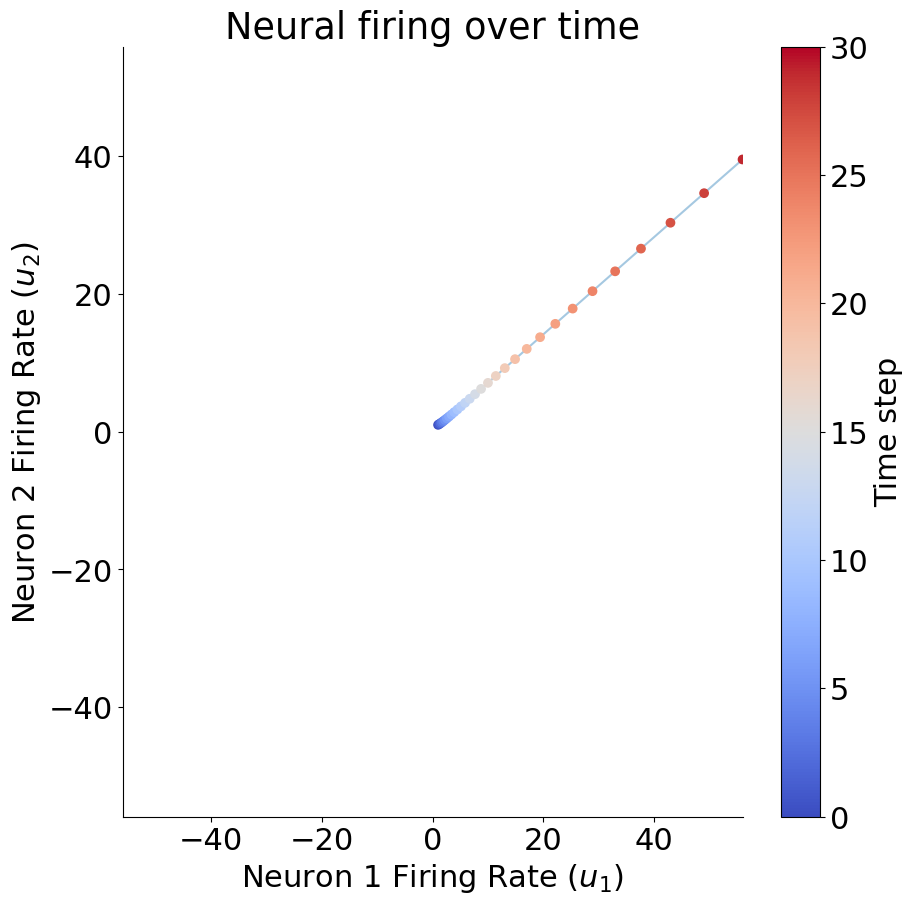

In [11]:
def circuit_implementation(W, u0, T):
  """ Simulate the responses of N neurons over time given their connections

  Args:
    W (ndarray): weight matrix of synaptic connections, should be N x N
    u0 (ndarray): initial condition or input vector, should be N,
    T (scalar): number of time steps to run simulation for

  Returns:
    u (ndarray): the neural responses over time, should be N x T

  """

  # Compute the number of neurons
  N = W.shape[0]

  # Initialize empty response array and initial condition
  u = np.zeros((N, T))
  u[:, 0]  = u0

  # Loop over time steps and compute u(t+1), store in correct column of u
  ... # your code here

  return u


# Define W, u0, T
W = np.array([[1, .2], [.1, 1]])
u0 = np.array([1, 1])
T = 30

u = circuit_implementation(W, u0, T)

print(u[:, -1])

# Visualize neural activities
plot_circuit_responses(u, W)

## C) Exploring trajectories

Use the same weight matrix but an initial condition of $\bar{u}_0 = \begin{bmatrix}
-1 \\
-1  \\
\end{bmatrix}$. Note that we are allowing our neural activities to be negative.

What are the activities of $N_1$ and $N_2$ after 30 timesteps?

**Your answer here**

What about with a weight matrix of
$$W = \begin{bmatrix} 0.2 & 0.1 \\
1 & 0.2 \\ \end{bmatrix}$$ and an initial condition $\bar{u}_0 = \begin{bmatrix}
1 \\
1  \\
\end{bmatrix}$.

What are the activities of $N_1$ and $N_2$ after 30 timesteps?

**Your answer here**

You can see different looking trajectories of neural firing rates with different initial conditions. With the initial firing rates of $\bar{u}_0 = \begin{bmatrix}
1 \\
1  \\
\end{bmatrix}$, the firing rates of both neurons were increasing to positive infinity. With an inital firing rate vector of $\bar{u}_0 = \begin{bmatrix}
-1 \\
-1  \\
\end{bmatrix}$, the firing rates of both neurons were becoming very negative (going towards negative infinity. With a different weight matrix and initial condition, the firing rates went to nearly zero. It turns out that the eigenvalues and eigenvectors of the weight matrix can help us predict what will happen for a given weight matrix and initial condition!

# Exercise 4: Eigenstuff effect on neural circuits

## A) Math of initial firing rate along an eigenvector

Remember in the video that we showed that
$$\bar{u}_{t} = W^t\bar{u}_0 $$

What would happen if $\bar{u}_0$ was an eigenvector of the weight matrix? In other words if the initial condition was along the eigenvector. Write $\bar{u}_t$ in terms of the eigenvalue and initial condition. Hint: exercise 2 might help.

**Your math answer here**

## B) Demonstration of initial firing rate along an eigenvector

Let's visualize what happens if the initial activities of the neurons lie along an eigenvector and think about how this depends on the eigenvalue.

The interactive demo below is the same visualization you saw in Section 1, but now we also plot the eigenvectors $\bar{v}_1$ and $\bar{v}_2$.

Questions:
1.  What happens if the eigenvalue is large (2)? Explain this trajectory in terms of the equation from part A.
2.  What happens if you move the eigenvalue from 2 to towards 0? Is there a point at which the direction of the trajectory of the dynamical system changes? Explain this shift in terms of the equation from part A.
3.  What happens with negative eigenvalues between 0 and -1? Explain the dynamical system trajectory in terms of the equation from part A.
4.  What happens with negative eigenvalues below -1? Explain the dynamical system trajectory in terms of the equation from part A.

In [13]:
# @markdown Execute this cell to enable the widget. Please be patient for a few seconds after you change the slider

@widgets.interact(eigenvalue = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.2))
def plot_system(eigenvalue):

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue, eigenvalue])

  # Get initial condition
  u0 = np.array([1, 1])

  # Get neural activities
  u = circuit_implementation(W, u0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])
  plt.show()

interactive(children=(FloatSlider(value=0.5, description='eigenvalue', max=2.0, min=-2.0, step=0.2), Output())…

**Your answers here**

## C) Math of other initial conditions

Can the eigenvectors and eigenvalues of the weight matrix help us figure out trajectories even when the initial condition isn't along an eigenvector?

Let's assume for now that our weight matrix has two distinct eigenvectors ($\bar{v}_1$ and $\bar{v}_2$) with corresponding eigenvalues $\lambda_1$ and $\lambda_2$, and that these eigenvectors form a basis for 2D space. That means we can write any vector in 2D space as a linear combination of our eigenvectors, including our initial activity vector:

$$\bar{u}_0 = c_1\bar{v}_1 + c_2\bar{v}_2 $$

Write $\bar{u}_t$ in terms of the c values ($c_1$ and $c_2$), the eigenvalues and eigenvectors.




**Your math answer here**

## D) Demonstration of other initial conditions

Before we get to the neural circuit, refresh your memory on linear combinations briefly by looking at our widget from tutorial 1 below. What happens when the absolute values of both scalar multiples of both vectors is big? What about when one is big and one is small? No need to write out answers here, just refresh your memory.

In [15]:
#@markdown Make sure you execute this cell to enable the widget! Move the sliders for “a” and “b”. After releasing the slider, be patient for a couple of seconds to see the desired change.


def plot_arrows(x, y, a_times_x, b_times_y):
  fig, ax = plt.subplots(figsize=(10, 7))

  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')

  ax.set_aspect('equal', adjustable='box')
  ax.set(xlim = [-10, 10], ylim = [-10, 10], xticks = np.arange(-10, 10), yticks = np.arange(-10, 10), xticklabels = [], yticklabels = [])

  ax.grid(alpha=.4)

  z = a_times_x + b_times_y
  z_arr = ax.arrow(0, 0, z[0], z[1], width=.08, color='k', length_includes_head = True);

  x_orig, = ax.plot([0, x[0]], [0, x[1]], '--', color='#648FFF')
  y_orig, = ax.plot([0, y[0]], [0, y[1]], '--',  color='#DC267F')

  ax_arr = ax.arrow(0, 0, a_times_x[0], a_times_x[1], width=.08, color='#648FFF', length_includes_head = True);
  by_arr = ax.arrow(0, 0, b_times_y[0], b_times_y[1], width=.08, color='#DC267F', length_includes_head = True);

  ax.plot([a_times_x[0], z[0]], [a_times_x[1], z[1]], '--k')
  ax.plot([b_times_y[0], z[0]], [b_times_y[1], z[1]], '--k')


  leg = ax.legend([x_orig, y_orig, ax_arr, by_arr, z_arr], [r"$\bar{x}$", r"$\bar{y}$", r"$a\bar{x}$", r"$b\bar{y}$", r"$\bar{z} = a\bar{x} + b\bar{y}$"], handlelength = 2, fontsize = 25, loc = 'center left', bbox_to_anchor=(1.05, .5))
  for handle, label in zip(leg.legendHandles, leg.texts):
      try:
          label.set_color(handle.get_facecolor())
      except:
          label.set_color(handle.get_color())
      #handle.set_visible(False)

@widgets.interact(a = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1), b = widgets.FloatSlider(value=1.0, min=-4, max=4, step=0.1))
def plot_linear_combination(a, b):
  x = np.array([3, 1])
  y = np.array([-1, 2])

  plot_arrows(x, y, a*x, b*y)
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='a', max=4.0, min=-4.0), FloatSlider(value=1.0, descr…


In the demo below, you can now change both eigenvalues and the initial condition (with `u0_1` setting neuron 1 initial activity and `u0_2` setting neuron 2 initial activity). We will only look at positive eigenvalues to keep things a little more simple. We also make sure the second eigenvalue is always the smaller one (just for better visualization purposes).

First, think each of the following questions through based on the equation we just arrived at and then play with the demo to see if you are correct.
$$\bar{u}_t = c_1\lambda_1^y\bar{v}_1 + c_2\lambda_2^y\bar{v}_2 $$

1.  What will happen when both eigenvalues are greater than 1? Does this depend on initial condition?  Set eigenvalue1 to 2 and eigenvalue2 to 1.2 and try out different initial conditions. What do you see?
2.  What will happen when both eigenvalues are less than 1?
3. What happens if one eigenvalue is below 1 and the other is above 1?

In [17]:
# @markdown Execute this cell to enable the widget (there is a small lag so be patient after changing sliders)
eigenvalue1 = widgets.FloatSlider(value=0.5, min=0.2, max=2, step=0.2)
eigenvalue2 = widgets.FloatSlider(value=0.2, min=0.2, max=0.5, step=0.2)
u0_1 = widgets.FloatSlider(value=1, min=-5, max=5, step=0.2)
u0_2 = widgets.FloatSlider(value=2, min=-5, max=5, step=0.2)

def update_range(*args):
    eigenvalue2.max = eigenvalue1.value - 0.2
eigenvalue1.observe(update_range, 'value')


def plot_system(eigenvalue1, eigenvalue2, u0_1, u0_2):

  # Get initial condition
  u0 = np.array([u0_1, u0_2])

  # Get weight matrix with specified eigenvalues
  W = get_eigval_specified_matrix([eigenvalue1, eigenvalue2])

  # Get neural activities
  u = circuit_implementation(W, u0, 10)

  # Visualize neural activities
  plot_circuit_responses(u, W, eigenstuff = True, xlim = [-15, 15], ylim = [-15, 15])
  plt.show()
widgets.interact(plot_system, eigenvalue1 = eigenvalue1, eigenvalue2 = eigenvalue2, u0_1 = u0_1, u0_2 = u0_2)

interactive(children=(FloatSlider(value=0.5, description='eigenvalue1', max=2.0, min=0.2, step=0.2), FloatSlid…

<function __main__.plot_system(eigenvalue1, eigenvalue2, u0_1, u0_2)>